In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.optimizers import Adam

from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.selection.tournament import TournamentSelection
from pymoo.optimize import minimize
from pymoo.termination import get_termination

from pathlib import Path
import itertools

2024-07-11 18:09:57.199784: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
path = Path(Path.cwd())
file_path = path / 'dataset' / 'adult_income.data'

In [3]:
column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status',
                'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss',
                'hours_per_week', 'native_country', 'income']

df = pd.read_csv(file_path, names=column_names, sep=',', skipinitialspace=True)
df.replace('?', pd.NA, inplace=True)
df.dropna(inplace=True)

df['income'] = df['income'].apply(lambda x: 1 if x == '>50K' else 0)
X = df.drop('income', axis=1)
y = df['income']

categorical_columns = ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']
continuous_columns = [col for col in X.columns if col not in categorical_columns]

X = pd.get_dummies(X, columns=categorical_columns)
one_hot_encoded_columns = [col for col in X.columns if col not in continuous_columns]

scaler = StandardScaler()
X_continuous = pd.DataFrame(scaler.fit_transform(X[continuous_columns]), index=X.index, columns=continuous_columns)
X = X_continuous.join(X[one_hot_encoded_columns])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
def fairness_calculator(protected_attribute_list, fairness_metric, X, y, y_pred):
    fairness_dictionary = {}

    for protected_attribute in protected_attribute_list:
        protected_attribute_index = X.columns.get_loc(protected_attribute)
        subset_y = []
        subset_y_pred = []
        indices = X.index[X.iloc[:, protected_attribute_index] == 1].to_list() 
        
        for i in indices:
            subset_y.append(y[i])
            subset_y_pred.append(y_pred[i])

        tn, fp, fn, tp = confusion_matrix(subset_y, subset_y_pred).ravel()
        
        if fairness_metric == 'Equal Opportunity':
            tpr = tp / (tp + fn)
            fairness = tpr
        elif fairness_metric == 'Equalized Odds':
            fpr = fp / (fp + tn)
            fairness = fpr
        elif fairness_metric == 'Disparate Impact':
            n = tn + fp + fn + tp
            ppp = (tp + fp / n)
            fairness = ppp
      
        fairness_dictionary[protected_attribute] = fairness

    fairness_difference = abs(fairness_dictionary[protected_attribute_list[0]] - fairness_dictionary[protected_attribute_list[1]])
    return fairness_difference

def lexicographic_tournament(pop, P, threshold, priority, **kwargs):
    n_tournaments, n_competitors = P.shape
    if priority == 1:
        objective_1_index = 0
        objective_2_index = 1
    elif priority == 2:
        objective_1_index = 1
        objective_2_index = 0
    else:
        print('ERROR')

    if n_competitors != 2:
        raise Exception("Only pressure=2 allowed for lexicographic tournament!")

    S = np.full(n_tournaments, -1, dtype=int)

    for i in range(n_tournaments):
        x, y = P[i]

        a_x = pop[x].F[objective_1_index]
        a_y = pop[y].F[objective_1_index]
        t_a = threshold[objective_1_index]

        if abs(a_x - a_y) > t_a:
            S[i] = x if a_x < a_y else y

        else:
            b_x = pop[x].F[objective_2_index]
            b_y = pop[y].F[objective_2_index]
            t_b = threshold[objective_2_index]

            if abs(b_x - b_y) < t_b:
                S[i] = x if b_x < b_y else y

            else:
                S[i] = x if a_x < a_y else y
    return S

In [5]:
def train_and_evaluate(lr, protected_attribute_list, fairness_metric):
    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=float(lr)), metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=0)

    loss, accuracy = model.evaluate(X_train, y_train, verbose=0)
    y_pred = model.predict(X_train)
    y_pred = (y_pred > 0.5).astype(int)
    y_pred = y_pred.flatten()
    y_pred = pd.Series(y_pred, index=X_train.index)

    fairness_difference = fairness_calculator(protected_attribute_list, fairness_metric, X_train, y_train, y_pred)

    return accuracy, fairness_difference

In [6]:
class LearningRateOptimizationProblem(Problem):
    def __init__(self, protected_attribute_list, fairness_metric):
        super().__init__(n_var=1, n_obj=2, n_constr=0, xl=0.0001, xu=0.1)
        self.protected_attribute_list = protected_attribute_list
        self.fairness_metric = fairness_metric

    def _evaluate(self, x, out, *args, **kwargs):
        results = np.array([train_and_evaluate(lr, self.protected_attribute_list, self.fairness_metric) for lr in x])
        negative_accuracy = -results[:, 0]
        fairness_diference = results[:, 1]
        out["F"] = np.column_stack([negative_accuracy, fairness_diference])

Starting combination: 2
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 947us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 936us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 938us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 995us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 944us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 954us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 953us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 993us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 932us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 970us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 943us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 938us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 995us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 950us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 977us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 923us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 927us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 940us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1m

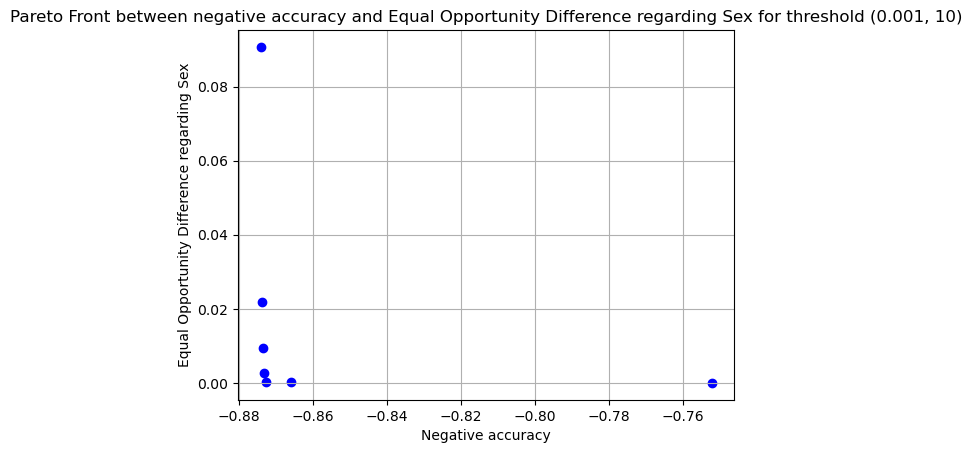

Finishing combination: 2
Starting combination: 3
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 931us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 954us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 974us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 950us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 992us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 975us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 993us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 969us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s

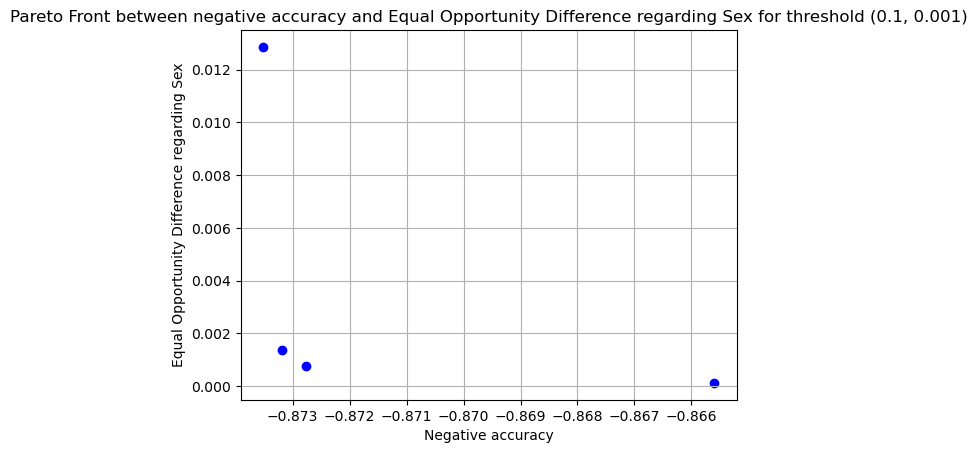

Finishing combination: 3
Starting combination: 4
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 866us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 939us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 865us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 880us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 957us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 896us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 886us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 966us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 893us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 880us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 890us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 904us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 904us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 967us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 890us/step
755/755 ━━━━━━━

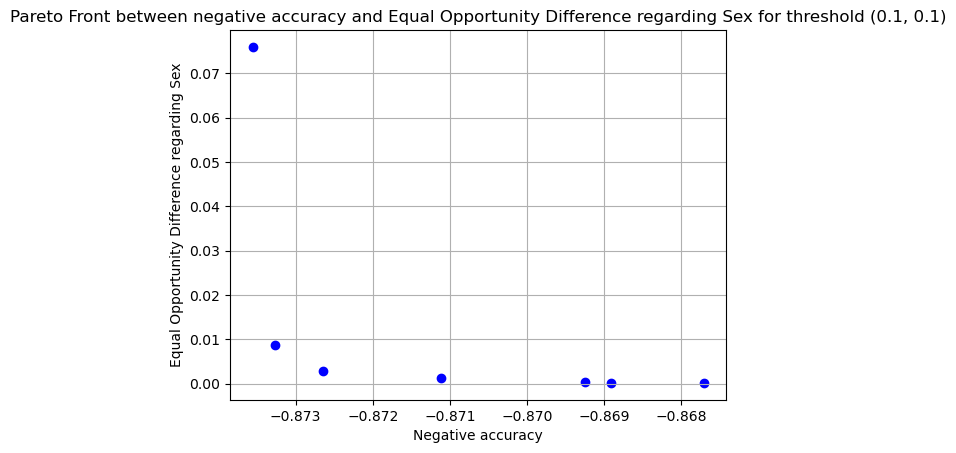

Finishing combination: 4
Starting combination: 5
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 938us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 875us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 875us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 946us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 897us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 880us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 895us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 889us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 898us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 879us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 914us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 902us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 897us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 959us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━

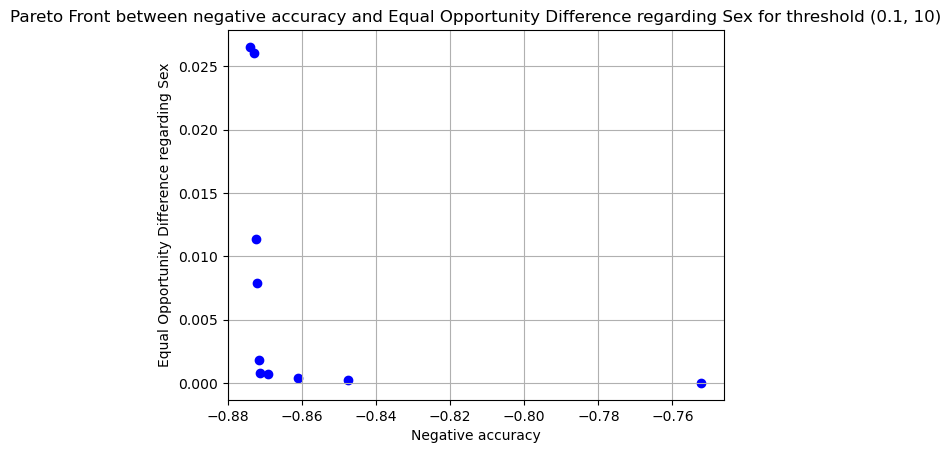

Finishing combination: 5
Starting combination: 6
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step   
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 981us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755

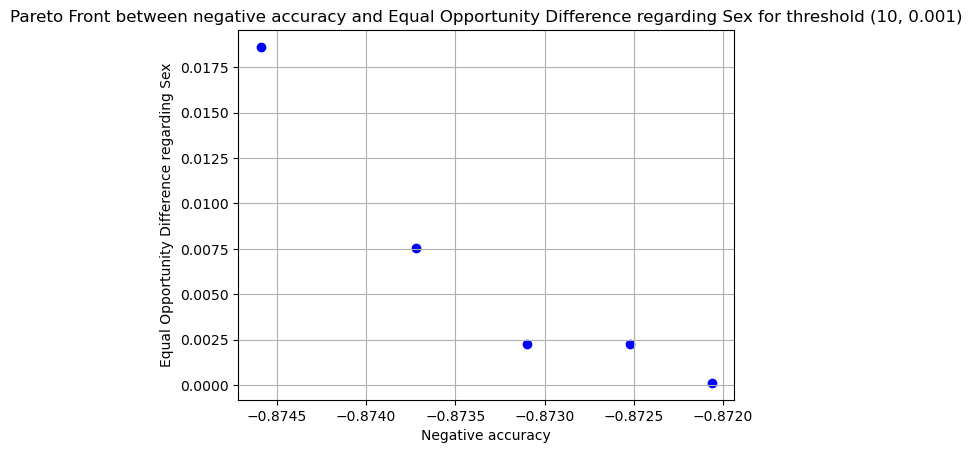

Finishing combination: 6
Starting combination: 7
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 964us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 932us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 901us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 910us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 995us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 915us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 900us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 892us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 920us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 888us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 913us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 979us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 924us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━

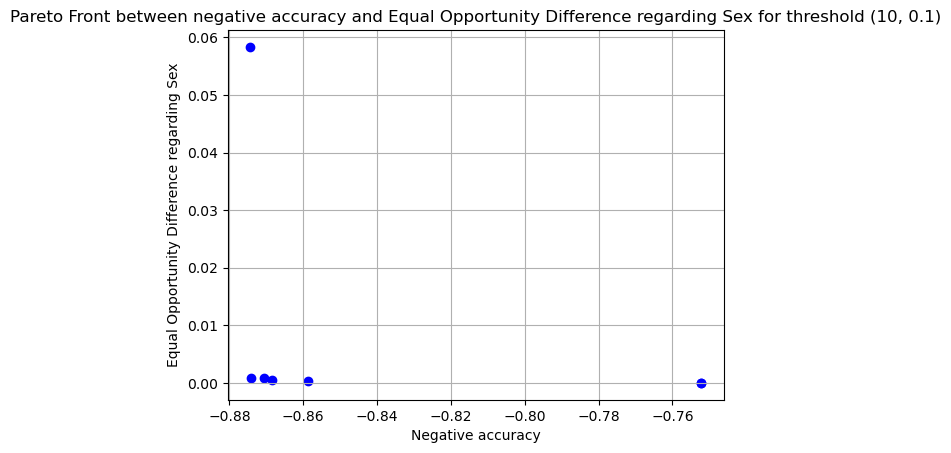

Finishing combination: 7
Starting combination: 8
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 642us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 820us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 659us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 772us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 656us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 761us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 677us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 682us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 993us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 844us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 932us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 742us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 876us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 698us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 694us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 663us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 803us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 699us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 688us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 643us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 713us/step
755/755

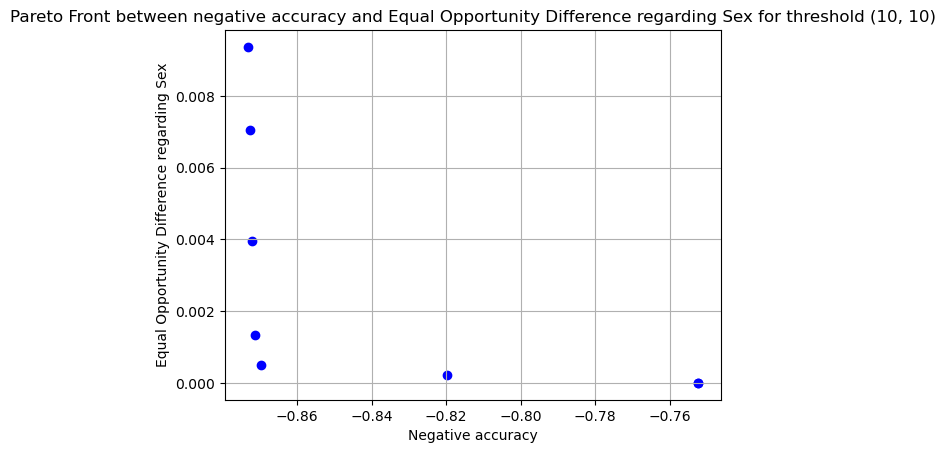

Finishing combination: 8
Starting combination: 9
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 633us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 839us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 770us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 779us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 663us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 866us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 829us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 662us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 804us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 835us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 886us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 865us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 886us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 787us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 694us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 740us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 759us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 691us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 688us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 816us/step
755/755 ━

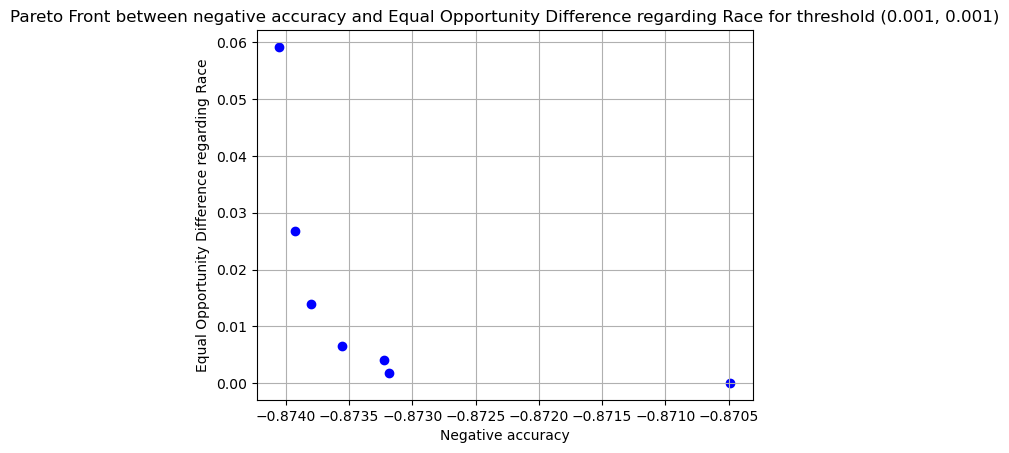

Finishing combination: 9
Starting combination: 10
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755

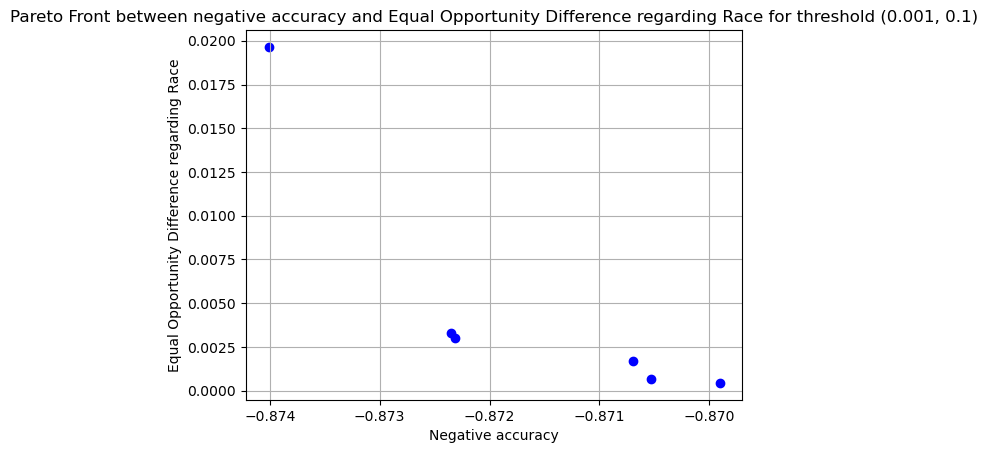

Finishing combination: 10
Starting combination: 11
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/75

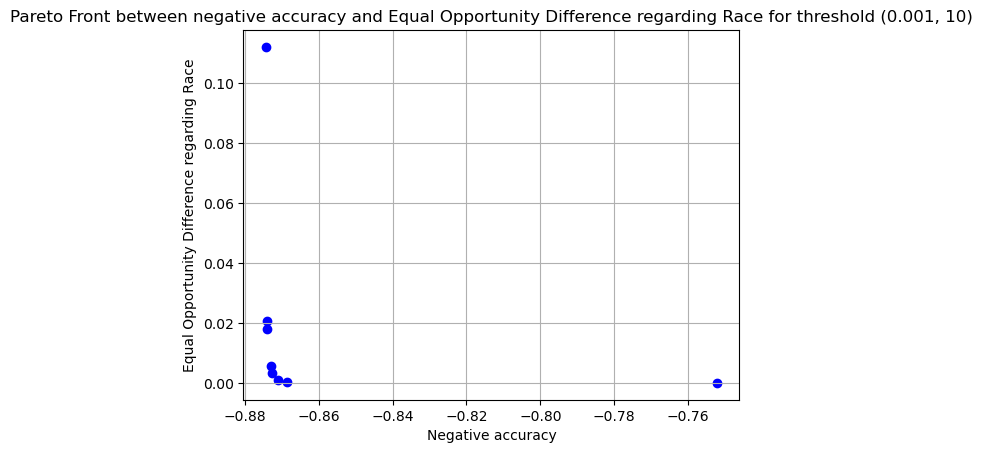

Finishing combination: 11
Starting combination: 12
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 966us/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/

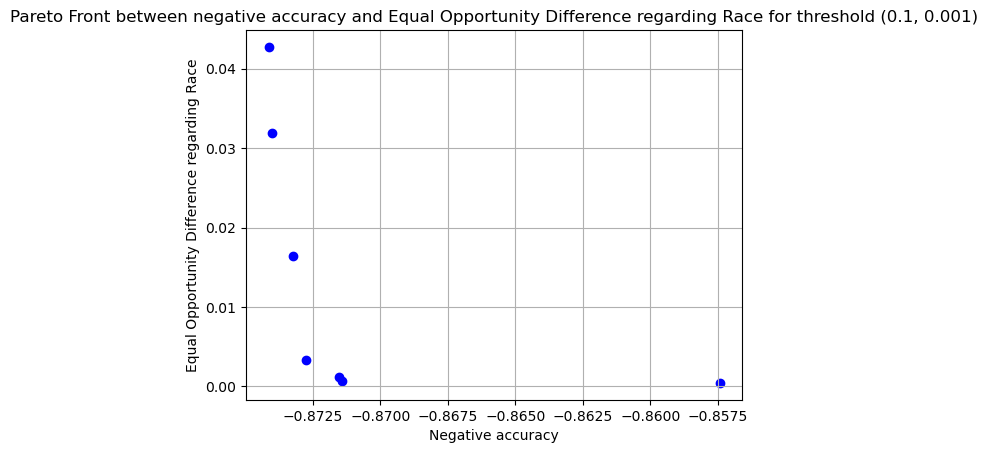

Finishing combination: 12
Starting combination: 13
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/75

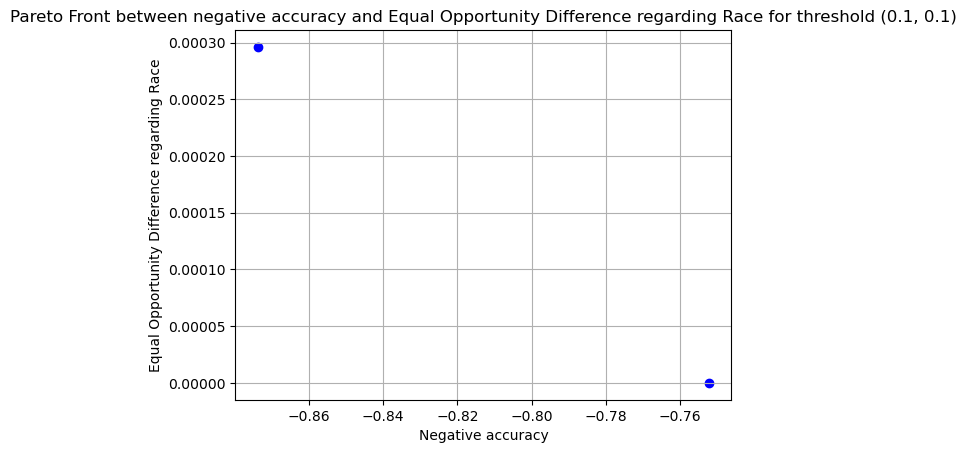

Finishing combination: 13
Starting combination: 14
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
755/75

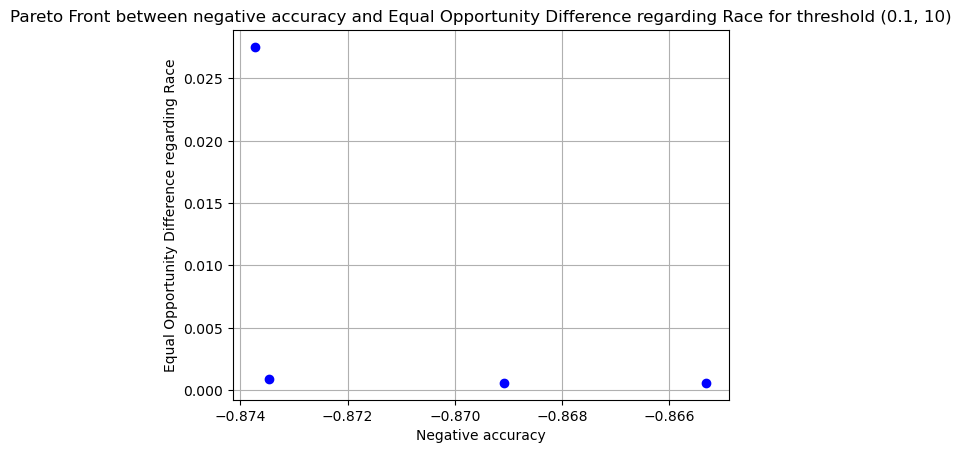

Finishing combination: 14
Starting combination: 15
755/755 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
755/755 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
385/755 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

KeyboardInterrupt: 

In [7]:
warnings.filterwarnings('ignore', category=UserWarning, module='keras')
population_size = 50
number_generations = 10
priority = 1 #accuracy
 
fairness_metric_vector = ['Equal Opportunity', 'Equalized Odds', 'Disparate Impact']
protected_attribute_vector = ['Sex', 'Race']
threshold = [1e-3, 1e-1, 10]
threshold_vector = list(itertools.product(threshold, threshold))
results_dictionary = {}

complete_combinations = list(itertools.product(fairness_metric_vector, protected_attribute_vector, threshold_vector))

start = 2 #state
for index in range(start, len(complete_combinations)):
    print (f'Starting combination: {index}')

    combination = complete_combinations[index]
    fairness_metric = combination[0]
    protected_attribute = combination[1]
    threshold = combination[2]

    if protected_attribute == 'Sex':
        protected_attribute_list = ['sex_Male', 'sex_Female'] 
    elif protected_attribute == 'Race':
        protected_attribute_list = ['race_White', 'race_Black']
    else:
        print('ERROR')
    
    selection = TournamentSelection(pressure=2, func_comp=lambda pop, P, **kwargs: lexicographic_tournament(pop, P, threshold, priority, **kwargs))
    problem = LearningRateOptimizationProblem(protected_attribute_list=protected_attribute_list, fairness_metric=fairness_metric)
    algorithm = NSGA2(pop_size=population_size, eliminate_duplicates=True, selection=selection)
    
    res = minimize(problem,
                algorithm,
                ('n_gen', number_generations),
                seed=1,
                verbose=True)

    solutions = res.F.tolist()
    learning_rates = res.X.tolist()

    title = f'Pareto Front between negative accuracy and {fairness_metric} Difference regarding {protected_attribute} for threshold {threshold}'
    xlabel = 'Negative accuracy'
    ylabel = f'{fairness_metric} Difference regarding {protected_attribute}'
    name = f'{fairness_metric}_{protected_attribute}_{str(threshold)}'

    results_dictionary[name] = {
        'priority': priority,
        'population size': population_size,
        'number generations': number_generations,

        'threshold fairness difference': threshold[0],
        'threshold negative accuracy': threshold[1],
        'fairness metric': fairness_metric,
        'protected attribute': protected_attribute,
        
        'solutions': solutions,
        'learning rate': learning_rates
    }
    
    df = pd.DataFrame(results_dictionary).T 
    df.to_excel('results.xlsx', index=True)

    print("Pareto front solutions (Fairness, Negative Accuracy):")
    for f in solutions:
        print(f)
    print("Corresponding learning rates:")
    for x in learning_rates:
        print(x)

    plt.figure()
    plt.scatter(res.F[:, 0], res.F[:, 1], c='blue', marker='o')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    file_out = path / 'images' / 'adult_income_dataset' / f'{name}.png'
    plt.savefig(file_out, dpi=300)
    plt.show()
    print (f'Finishing combination: {index}')